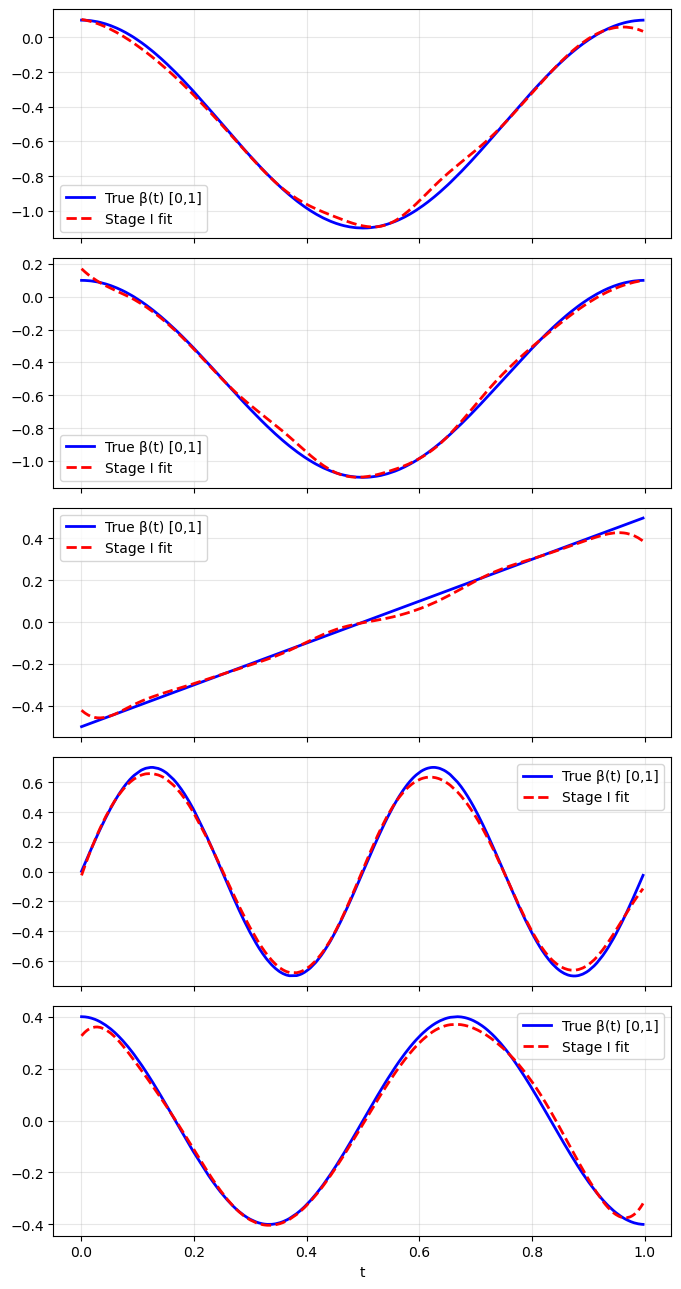

[Stage I] m1=14 (应为 N+k=14), λ1*=5.248e-01
[Stage I] 选中的变量组：[1, 2, 3, 4, 5, 20, 27, 37, 43, 57, 61, 75, 81]
[Stage I] 指标：TP=5, FP=8, FN=0, Precision=0.385, Recall=1.000, F1=0.556
[Stage I (Adaptive)] λ1_ad=1.415e-01
[Stage I (Adaptive)] 选中的变量组：[1, 2, 3, 4, 5]
[Stage I (Adaptive)] 指标：TP=5, FP=0, FN=0, Precision=1.000, Recall=1.000, F1=1.000


In [18]:
# ============================ 阶段 I：在 [0,1] 上训练 ============================
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.interpolate import BSpline

# ---------- 更平缓的 C^2 掩码（接口不变） ----------
def ghost_mask(u, a=0.3, b=0.6):
    """
    在 [a,b] 上严格为 0，区间外平滑升至 1；C^2，统一尺度。
    调整 ALPHA 可让过渡更“缓”（大）或更“陡”（小）。
    """
    u = np.asarray(u, dtype=float)
    if a > b: a, b = b, a
    ALPHA = 0.20
    Uspan = float(np.ptp(u)) if np.ptp(u) > 0 else 1.0
    delta = ALPHA * Uspan
    def s(x):
        x = np.clip(x, 0.0, 1.0)
        return x*x*x*(x*(x*6 - 15) + 10)
    t = np.maximum(0.0, np.maximum(a - u, u - b))
    return s(t / (delta + 1e-12))

# ---------- 核心工具 ----------
def make_open_uniform_knots(a, b, k, n_inner):
    inner = np.linspace(a, b, n_inner+2)[1:-1] if n_inner>0 else np.array([])
    return np.r_[np.repeat(a, k+1), inner, np.repeat(b, k+1)]

def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k+1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def build_vcm_design(B, X):
    n, m = B.shape; P = X.shape[1]
    out = np.zeros((n, m*P))
    for p in range(P):
        out[:, p*m:(p+1)*m] = X[:, [p]] * B
    return out

def split_blocks(vec, m, P): return [vec[p*m:(p+1)*m] for p in range(P)]

def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid); w[0]*=0.5; w[-1]*=0.5; w *= (b-a)/(grid-1)
    return B.T @ (B * w[:,None])

def group_weights(B, X):
    row_e = np.sum(B*B, axis=1)
    return np.sqrt((X**2 * row_e[:,None]).sum(0)/B.shape[0] + 1e-12)

def lambda_max_R(XtB, y, m, R):
    L = np.linalg.cholesky(R); P = XtB.shape[1]//m; lam = 0.0
    for p in range(P):
        g = XtB[:, p*m:(p+1)*m].T @ y
        u = np.linalg.solve(L.T, g)
        lam = max(lam, float(norm(u)))
    return lam

def group_soft_thresh(blocks, tau, R, lam, w):
    out=[]
    for v,wp in zip(blocks,w):
        nr=float(np.sqrt(max(0.0, v.T@R@v))); thr=tau*lam*wp
        out.append(np.zeros_like(v) if nr<=thr else (1-thr/nr)*v)
    return out

def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=3000, tol=1e-6):
    d=m*P; Ls=float(np.linalg.norm(XtX,2)); Ls = Ls if (np.isfinite(Ls) and Ls>0) else 1.0
    step=1.0/Ls; c=np.zeros(d); z=c.copy(); tN=1.0
    for _ in range(max_iter):
        grad= XtX@z - Xty
        yv  = z - step*grad
        yb  = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))
        t_new = 0.5*(1+np.sqrt(1+4*tN*tN))
        z = c_new + (tN-1)/t_new*(c_new-c)
        if norm(c_new-c) <= tol*max(1.0, norm(c)): return c_new
        c, tN = c_new, t_new
    return c

def kfold_indices(n,K=5,seed=0):
    rng=np.random.default_rng(seed); idx=np.arange(n); rng.shuffle(idx)
    return np.array_split(idx,K)

def cv_select_lambda(B,X,y,R,w,lams,K=5,seed=2025,use_1se=True):
    n,m=B.shape; P=X.shape[1]; folds=kfold_indices(n,K,seed)
    mse=np.zeros((len(lams),K))
    for li,lam in enumerate(lams):
        for kf,val in enumerate(folds):
            tr=np.setdiff1d(np.arange(n),val)
            Btr,Bv=B[tr],B[val]; Xtr,Xv=X[tr],X[val]; ytr,yv=y[tr],y[val]
            XtBtr=build_vcm_design(Btr,Xtr); XtBv=build_vcm_design(Bv,Xv)
            XtX=XtBtr.T@XtBtr; Xty=XtBtr.T@ytr
            c=fista_group_lasso(XtX,Xty,lam,m,P,R,w)
            mse[li,kf]=np.mean((yv - XtBv@c)**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(K); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    return float(lams[best])

# —— 选择/评估/Adaptive —— #
def group_selection_by_Rnorm(coef_blocks, R, tol=1e-6):
    r = np.array([float(np.sqrt(max(0.0, cb.T @ R @ cb))) for cb in coef_blocks])
    sel = np.where(r > tol)[0].tolist()
    return sel, r

def eval_selection(selected, signal_idx, P):
    S=set(signal_idx); Sel=set(selected)
    TP=len(S&Sel); FP=len(Sel-S); FN=len(S-Sel)
    precision=TP/max(1,TP+FP); recall=TP/max(1,TP+FN)
    f1=0.0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)
    return dict(TP=TP,FP=FP,FN=FN,precision=precision,recall=recall,f1=f1)

def print_selection_report(tag, selected, metrics, max_show=30):
    print(f"\n[{tag}] 选中 {len(selected)} 组（前{max_show}）：{sorted(selected)[:max_show]}")
    print(f"[{tag}] TP={metrics['TP']}, FP={metrics['FP']}, FN={metrics['FN']} | "
          f"Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")

def adaptive_once(B, X, y, R, coef_blocks_init, use_1se=True, delta=1.0, eps=1e-6):
    n, m = B.shape; P = X.shape[1]
    r0 = np.array([float(np.sqrt(max(0.0, cb.T @ R @ cb))) for cb in coef_blocks_init])
    w_adapt = 1.0 / (r0 + eps)**delta
    XtB = build_vcm_design(B, X)
    lam_max = lambda_max_R(XtB, y, m, R)
    lambdas = np.geomspace(lam_max, lam_max*5e-4, 30)
    # 简易CV（带权）
    folds = kfold_indices(n,5,2025)
    mse=np.zeros((len(lambdas),5))
    for li,lam in enumerate(lambdas):
        for kf,val in enumerate(folds):
            tr=np.setdiff1d(np.arange(n),val)
            Btr,Bv=B[tr],B[val]; Xtr,Xv=X[tr],X[val]; ytr,yv=y[tr],y[val]
            XtBtr=build_vcm_design(Btr,Xtr); XtBv=build_vcm_design(Bv,Xv)
            XtX=XtBtr.T@XtBtr; Xty=XtBtr.T@ytr
            c=fista_group_lasso(XtX,Xty,lam,m,P,R,w_adapt)
            mse[li,kf]=np.mean((yv - XtBv@c)**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(5); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    lam_ad=lambdas[best]
    c_ad=fista_group_lasso(XtB.T@XtB, XtB.T@y, lam_ad, m, P, R, w_adapt, max_iter=6000, tol=1e-7)
    blocks_ad=split_blocks(c_ad, m, P)
    return lam_ad, c_ad, blocks_ad

# ---------- 数据与超参 ----------
def true_funcs(scales=None):
    if scales is None: scales=[1.0,1.0,1.0,1.0,1.0]  # 控制幅度
    return [
        lambda u: scales[0]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[1]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[2]*(u-0.5),
        lambda u: scales[3]*(0.7*np.sin(4*np.pi*u)),
        lambda u: scales[4]*(0.4*np.cos(3*np.pi*u)),
    ]

def gen_interval(funcs,a,b,n,P,signal_idx,sigma,seed,normalize_within=True):
    rng=np.random.default_rng(seed)
    t=np.sort(rng.uniform(a,b,n))
    X=rng.standard_normal((n,P)); X=(X-X.mean(0))/(X.std(0)+1e-12)
    u=(t-a)/(b-a) if normalize_within else t
    beta=np.zeros((n,P))
    for j,idx in enumerate(signal_idx):
        beta[:,idx]=funcs[j%len(funcs)](u)
    y=(X*beta).sum(1)+sigma*rng.standard_normal(n)
    return t,X,y,beta

# 超参
k=3; n_inner=10
P=100; n=400; noise_sigma=0.1
seed_data=0; seed_cv=2025; use_1se=True
signal_idx=[1,2,3,4,5]

# —— 阶段 I —— #
funcs=true_funcs()
t1,X1,y1,beta1=gen_interval(funcs,0,1,n,P,signal_idx,noise_sigma,seed_data,normalize_within=True)
N = n_inner + 1
knots1 = make_open_uniform_knots(0.0,1.0,k,n_inner)     # m1 = N + k
B1     = bspline_design_matrix(t1, knots1, k); m1=B1.shape[1]
XBt1   = build_vcm_design(B1, X1)
R1     = gram_R(knots1, k, 0.0, 1.0)
w1     = group_weights(B1, X1)
lammax = lambda_max_R(XBt1, y1, m1, R1)
lams   = np.geomspace(lammax, lammax*5e-4, 30)

lam1 = cv_select_lambda(B1, X1, y1, R1, w1, lams, K=5, seed=seed_cv, use_1se=use_1se)
c1   = fista_group_lasso(XBt1.T@XBt1, XBt1.T@y1, lam1, m1, P, R1, w1)
coef1_blocks = split_blocks(c1, m1, P)

# 可视化（前 r 个有效组）
r = min(len(signal_idx), 5)
betahat1 = np.column_stack([B1 @ coef1_blocks[p] for p in range(P)])
order = np.argsort(t1)
fig,axs=plt.subplots(r,1,figsize=(7,2.0*r+3),sharex=True)
for ax,p in zip(axs, signal_idx[:r]):
    ax.plot(t1[order], beta1[order,p], 'b', lw=2, label='True β(t) [0,1]')
    ax.plot(t1[order], betahat1[order,p], 'r--', lw=2, label='Stage I fit')
    ax.grid(alpha=0.3); ax.legend()
axs[-1].set_xlabel("t"); plt.tight_layout(); plt.show()

# 选择 & 性能
sel1, _ = group_selection_by_Rnorm(coef1_blocks, R1, tol=1e-6)
m1x = eval_selection(sel1, signal_idx, P)
print(f"[Stage I] m1={m1} (应为 N+k={N+k}), λ1*={lam1:.3e}")
print(f"[Stage I] 选中的变量组：{sorted(sel1)[:30]}")
print(f"[Stage I] 指标：TP={m1x['TP']}, FP={m1x['FP']}, FN={m1x['FN']}, "
      f"Precision={m1x['precision']:.3f}, Recall={m1x['recall']:.3f}, F1={m1x['f1']:.3f}")

# 若误选，做一次 Adaptive
if m1x["FP"]>0 or m1x["FN"]>0:
    lam1_ad, c1_ad, blocks1_ad = adaptive_once(B1, X1, y1, R1, coef1_blocks, use_1se=use_1se)
    sel1_ad, _ = group_selection_by_Rnorm(blocks1_ad, R1, tol=1e-6)
    m1x_ad = eval_selection(sel1_ad, signal_idx, P)
    print(f"[Stage I (Adaptive)] λ1_ad={lam1_ad:.3e}")
    print(f"[Stage I (Adaptive)] 选中的变量组：{sorted(sel1_ad)[:30]}")
    print(f"[Stage I (Adaptive)] 指标：TP={m1x_ad['TP']}, FP={m1x_ad['FP']}, FN={m1x_ad['FN']}, "
          f"Precision={m1x_ad['precision']:.3f}, Recall={m1x_ad['recall']:.3f}, F1={m1x_ad['f1']:.3f}")


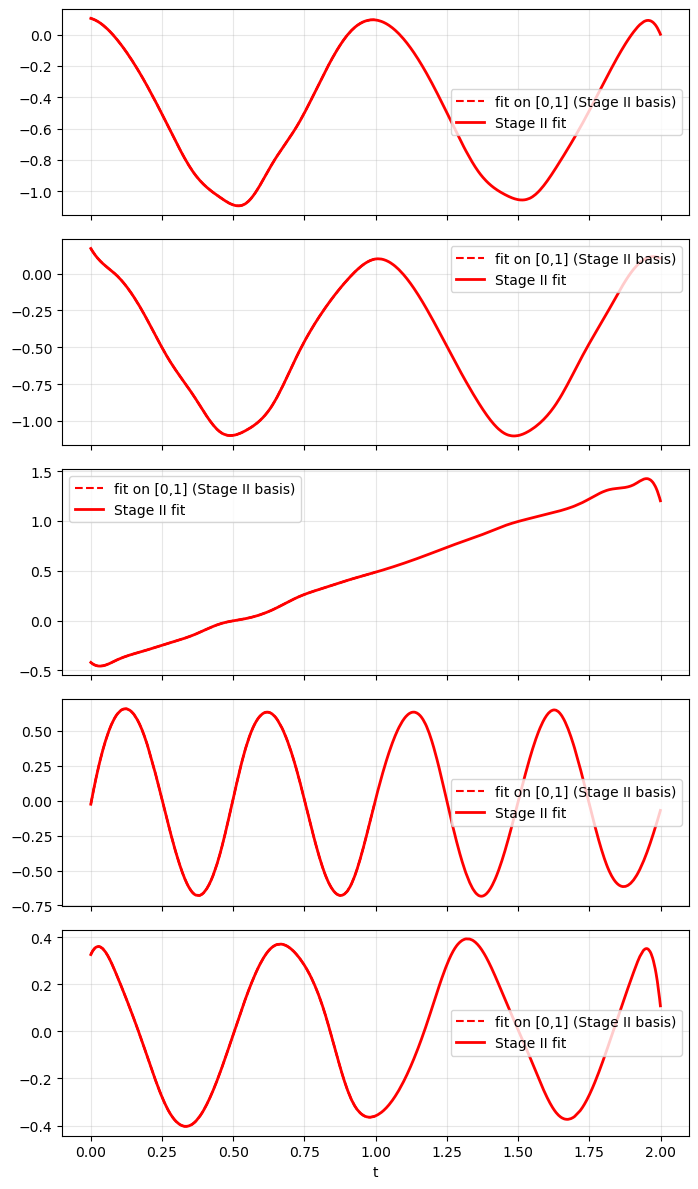

[Stage II] |Go|=10, |Gc∪Gn|=14, λ2*=8.387e-01, Train RMSE=0.0964


In [ ]:
# ============================ 阶段 II：从 [0,1] 扩到 [0,2]（含维度对齐修复 + CN-自适应） ============================
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# —— 需要阶段 I 里已存在：knots1, c1, t1, X1, y1，以及 k, n_inner, P, n, signal_idx, noise_sigma, seed_data, seed_cv, use_1se —— #

# ---------- 复用工具 ----------
def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k+1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def build_vcm_design(B, X):
    n, m = B.shape; P = X.shape[1]
    out = np.zeros((n, m*P))
    for p in range(P): out[:, p*m:(p+1)*m] = X[:, [p]] * B
    return out

def split_blocks(vec, m, P): return [vec[p*m:(p+1)*m] for p in range(P)]

def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid); w[0]*=0.5; w[-1]*=0.5; w *= (b-a)/(grid-1)
    return B.T @ (B * w[:,None])

def group_weights(B, X):
    row_e = np.sum(B*B, axis=1)
    return np.sqrt((X**2 * row_e[:,None]).sum(0)/B.shape[0] + 1e-12)

def lambda_max_R(XtB, y, m, R):
    L = np.linalg.cholesky(R); P = XtB.shape[1]//m; lam=0.0
    for p in range(P):
        g = XtB[:, p*m:(p+1)*m].T @ y
        u = np.linalg.solve(L.T, g); lam=max(lam, float(norm(u)))
    return lam

def group_soft_thresh(blocks, tau, R, lam, w):
    out=[]
    for v,wp in zip(blocks,w):
        nr=float(np.sqrt(max(0.0, v.T@R@v))); thr=tau*lam*wp
        out.append(np.zeros_like(v) if nr<=thr else (1-thr/nr)*v)
    return out

def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=3000, tol=1e-6):
    d=m*P; Ls=float(np.linalg.norm(XtX,2)); Ls=Ls if (np.isfinite(Ls) and Ls>0) else 1.0
    step=1.0/Ls; c=np.zeros(d); z=c.copy(); tN=1.0
    for _ in range(max_iter):
        grad= XtX@z - Xty
        yv  = z - step*grad
        yb  = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))
        t_new = 0.5*(1+np.sqrt(1+4*tN*tN))
        z = c_new + (tN-1)/t_new*(c_new-c)
        if norm(c_new-c) <= tol*max(1.0, norm(c)): return c_new
        c, tN = c_new, t_new
    return c

def kfold_indices(n,K=5,seed=0):
    rng=np.random.default_rng(seed); idx=np.arange(n); rng.shuffle(idx)
    return np.array_split(idx,K)

def cv_select_lambda_frozen(B_full, X, y, R_full, lambdas, idx_o, c_o_mat, K=5, seed=2025, use_1se=True):
    n_all, m2 = B_full.shape; P = X.shape[1]
    folds = kfold_indices(n_all, K, seed)
    idx_cn = np.setdiff1d(np.arange(m2), idx_o)
    mse = np.zeros((len(lambdas), K))
    for li, lam in enumerate(lambdas):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n_all), val)
            Btr,Bv = B_full[tr], B_full[val]
            Xtr,Xv = X[tr], X[val]
            ytr,yv = y[tr], y[val]
            Btr_o,Bv_o   = Btr[:, idx_o], Bv[:, idx_o]
            Btr_cn,Bv_cn = Btr[:, idx_cn], Bv[:, idx_cn]
            frozen_tr = np.sum(Xtr*(Btr_o@c_o_mat.T), axis=1)
            frozen_v  = np.sum(Xv *(Bv_o @c_o_mat.T), axis=1)
            ytr_res, yv_res = ytr - frozen_tr, yv - frozen_v
            R_cn = R_full[np.ix_(idx_cn, idx_cn)]
            w_cn = group_weights(Btr_cn, Xtr)
            XtBtr=build_vcm_design(Btr_cn, Xtr); XtBv=build_vcm_design(Bv_cn, Xv)
            XtX = XtBtr.T@XtBtr; Xty = XtBtr.T@ytr_res; m_cn=Btr_cn.shape[1]
            c = fista_group_lasso(XtX,Xty,lam,m_cn,P,R_cn,w_cn)
            mse[li,kf]=np.mean((yv - (frozen_v + XtBv@c))**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(K); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    return float(lambdas[best]), mm, mse

# —— “4 结点匹配”：找出在释放 1 的重复后仍保持不变的旧基（两阶段一一对应）—— #
def map_unchanged_bases_simple(knots1, knots2, k, eps=1e-12):
    t1=np.asarray(knots1); t2=np.asarray(knots2)
    m1=len(t1)-(k+1); m2=len(t2)-(k+1)
    S1=np.stack([t1[j:j+k+1] for j in range(m1)],0)
    S2=np.stack([t2[j:j+k+1] for j in range(m2)],0)
    cand1=np.where(S1[:,-1] <= 1.0+eps)[0]
    cand2=np.where(S2[:,-1] <= 1.0+eps)[0]
    pairs=[]
    for i in cand1:
        a=S1[i]
        hit=np.where(np.all(np.abs(S2[cand2]-a)<eps, axis=1))[0]
        if hit.size==1:
            pairs.append((i, int(cand2[hit[0]])))
    if len(pairs)==0:
        return np.array([],int), np.array([],int)
    idx1_keep, idx2_match = zip(*pairs)
    return np.array(idx1_keep,int), np.array(idx2_match,int)

# ---------- 生成 [1,2] 数据 ----------
def true_funcs(scales=None):
    if scales is None: scales=[1.0,1.0,1.0,1.0,1.0]
    return [
        lambda u: scales[0]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[1]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[2]*(u-0.5),
        lambda u: scales[3]*(0.7*np.sin(4*np.pi*u)),
        lambda u: scales[4]*(0.4*np.cos(3*np.pi*u)),
    ]
def gen_interval(funcs,a,b,n,P,signal_idx,sigma,seed):
    rng=np.random.default_rng(seed)
    t=np.sort(rng.uniform(a,b,n))
    X=rng.standard_normal((n,P)); X=(X-X.mean(0))/(X.std(0)+1e-12)
    beta=np.zeros((n,P))
    for j,idx in enumerate(signal_idx):
        beta[:,idx]=funcs[j%len(funcs)](t)
    y=(X*beta).sum(1)+sigma*rng.standard_normal(n)
    return t,X,y,beta

# ---------- 阶段 II 主流程 ----------
# 1) knots2：仅 0/2 端点重复；1 仅一次（内部结点）
left_inner  = np.linspace(0,1,n_inner+2)[1:-1]
right_inner = np.linspace(1,2,n_inner+2)[1:-1]
knots2 = np.r_[np.repeat(0.0,k+1), left_inner, 1.0, right_inner[1:], np.repeat(2.0,k+1)]

# 2) 一一对应的“可冻结旧基”索引（阶段一 vs 阶段二）
idx1_o_keep, idx2_o_matched = map_unchanged_bases_simple(knots1, knots2, k)

# （可选）边界放宽 r_relax：把最靠近 1 的若干可冻结基也放入可调集合
r_relax = 2
if r_relax>0 and len(idx2_o_matched)>r_relax:
    right_end = np.array([knots2[i + k] for i in idx2_o_matched])
    order = np.argsort(right_end)
    move_mask = np.zeros_like(idx2_o_matched, dtype=bool)
    move_mask[order[-r_relax:]] = True
    idx2_o = idx2_o_matched[~move_mask]
    idx1_o = idx1_o_keep[~move_mask]
else:
    idx2_o = idx2_o_matched
    idx1_o = idx1_o_keep

# 3) 数据拼接、基矩阵与切块（注意 O 与 idx1_o/idx2_o 一一对应）
funcs = true_funcs()
t2,X2,y2,_ = gen_interval(funcs,1,2,n,P,signal_idx,noise_sigma,seed_data+1)
t_all = np.r_[t1, t2]; X_all = np.vstack([X1, X2]); y_all = np.r_[y1, y2]

B2 = bspline_design_matrix(t_all, knots2, k)
idx2_all = np.arange(B2.shape[1])
idx2_cn  = np.setdiff1d(idx2_all, idx2_o)
B2_o  = B2[:, idx2_o]
B2_cn = B2[:, idx2_cn]

# 4) 冻结系数矩阵 (P, |O|) —— 与 idx2_o 的列顺序严格一致
coef1_blocks = split_blocks(c1, len(knots1)-(k+1), P)
c_o_mat = np.stack([coef1_blocks[p][idx1_o].astype(float, copy=True) for p in range(P)], axis=0)  # (P, |O|)

# 5) 冻结贡献
def frozen_contrib(B_o, X, c_o): return np.sum(X * (B_o @ c_o.T), axis=1)
frozen_y = frozen_contrib(B2_o, X_all, c_o_mat)
y_res    = y_all - frozen_y

# 6) 子问题：R_cn、权重、λ 路径（都在 cn 子空间）
R2     = gram_R(knots2, k, 0.0, 2.0)
R2_cn  = R2[np.ix_(idx2_cn, idx2_cn)]
w2_cn  = group_weights(B2_cn, X_all)
XtB_cn = build_vcm_design(B2_cn, X_all)
lam2_max = lambda_max_R(XtB_cn, y_res, B2_cn.shape[1], R2_cn)
lams2 = np.geomspace(lam2_max, lam2_max*5e-4, 30)

# 7) 逐折冻结CV 选 λ2，并在 (C∪N) 上求解（初解）
lam2, _, _ = cv_select_lambda_frozen(B2, X_all, y_all, R2, lams2, idx_o=idx2_o, c_o_mat=c_o_mat, K=5, seed=seed_cv, use_1se=use_1se)
XtX2 = XtB_cn.T @ XtB_cn; Xty2 = XtB_cn.T @ y_res
c2   = fista_group_lasso(XtX2, Xty2, lam2, B2_cn.shape[1], P, R2_cn, w2_cn)

# ========== 7.5) CN 子空间一次 Adaptive ==========
# 基于初解 c2 的组 R-范数构造自适应权重，并在 CN 子空间重新 CV + 求解
blocks_cn_0 = split_blocks(c2, B2_cn.shape[1], P)
r0_cn = np.array([float(np.sqrt(max(0.0, cb.T @ R2_cn @ cb))) for cb in blocks_cn_0])
eps, delta = 1e-6, 1.0
w2_cn_ad = 1.0 / (r0_cn + eps)**delta

# 自适应阶段的 λ 路径与 K 折 CV（固定冻结项不变，仍在 y_res & B2_cn 上评估）
lam2_max_ad = lambda_max_R(XtB_cn, y_res, B2_cn.shape[1], R2_cn)
lams2_ad = np.geomspace(lam2_max_ad, lam2_max_ad*5e-4, 30)
folds = kfold_indices(len(y_res), K=5, seed=seed_cv)

mse_ad = np.zeros((len(lams2_ad), 5))
for li, lam in enumerate(lams2_ad):
    for kf, val in enumerate(folds):
        tr = np.setdiff1d(np.arange(len(y_res)), val)
        Btr, Bv = B2_cn[tr], B2_cn[val]
        Xtr, Xv = X_all[tr], X_all[val]
        ytr_res, yv_res = y_res[tr], y_res[val]
        XtBtr = build_vcm_design(Btr, Xtr); XtBv = build_vcm_design(Bv, Xv)
        XtX = XtBtr.T @ XtBtr; Xty = XtBtr.T @ ytr_res
        c_tmp = fista_group_lasso(XtX, Xty, lam, B2_cn.shape[1], P, R2_cn, w2_cn_ad,
                                  max_iter=6000, tol=1e-7)
        mse_ad[li, kf] = np.mean((yv_res - XtBv @ c_tmp)**2)

mm_ad = mse_ad.mean(1); best_ad = int(np.argmin(mm_ad))
if use_1se:
    se_ad = mse_ad.std(1, ddof=1)/np.sqrt(5); thr_ad = mm_ad[best_ad] + se_ad[best_ad]
    best_ad = int(np.where(mm_ad <= thr_ad)[0][0])
lam2_ad = float(lams2_ad[best_ad])

# 自适应最终解（仍在 CN 子空间）
XtX_cn = XtB_cn.T @ XtB_cn; Xty_cn = XtB_cn.T @ y_res
c2_ad = fista_group_lasso(XtX_cn, Xty_cn, lam2_ad, B2_cn.shape[1], P, R2_cn, w2_cn_ad,
                          max_iter=6000, tol=1e-7)

# 8) 拼回完整系数并可视化（对前 r 个有效组）
blocks_cn = split_blocks(c2, B2_cn.shape[1], P)
blocks_cn_ad = split_blocks(c2_ad, B2_cn.shape[1], P)
coef2=[]; coef2_ad=[]
for p in range(P):
    c_full = np.zeros(B2.shape[1]); c_full[idx2_o]  = c_o_mat[p]; c_full[idx2_cn] = blocks_cn[p]
    c_full_ad = np.zeros(B2.shape[1]); c_full_ad[idx2_o]  = c_o_mat[p]; c_full_ad[idx2_cn] = blocks_cn_ad[p]
    coef2.append(c_full); coef2_ad.append(c_full_ad)

# 可视化（可选）
r = min(len(signal_idx), 5)
B_eval = bspline_design_matrix(t_all, knots2, k)
betahat2    = np.column_stack([B_eval @ coef2[p]    for p in range(P)])
betahat2_ad = np.column_stack([B_eval @ coef2_ad[p] for p in range(P)])
order = np.argsort(t_all)
fig,axs=plt.subplots(r,1,figsize=(7,1.8*r+3),sharex=True)
for ax,p in zip(axs, signal_idx[:r]):
    ax.plot(t_all[order], betahat2[order, p], 'r--', lw=1.2, label='Stage II (init)')
    ax.plot(t_all[order], betahat2_ad[order, p], 'r',   lw=2.0, label='Stage II (adaptive CN)')
    ax.grid(alpha=0.3); ax.legend()
axs[-1].set_xlabel("t"); plt.tight_layout(); plt.show()

# 训练 RMSE（全量）
yhat_all_init = frozen_y + build_vcm_design(B2_cn, X_all) @ c2
rmse_all_init = float(np.sqrt(np.mean((y_all - yhat_all_init)**2)))
yhat_all_ad   = frozen_y + build_vcm_design(B2_cn, X_all) @ c2_ad
rmse_all_ad   = float(np.sqrt(np.mean((y_all - yhat_all_ad)**2)))

print(f"[Stage II] |Go|={len(idx2_o)}, |Gc∪Gn|={len(idx2_cn)}, λ2*={lam2:.3e}, Train RMSE={rmse_all_init:.4f}")
print(f"[Stage II (Adaptive on CN)] λ2_ad*={lam2_ad:.3e}, Train RMSE={rmse_all_ad:.4f}")


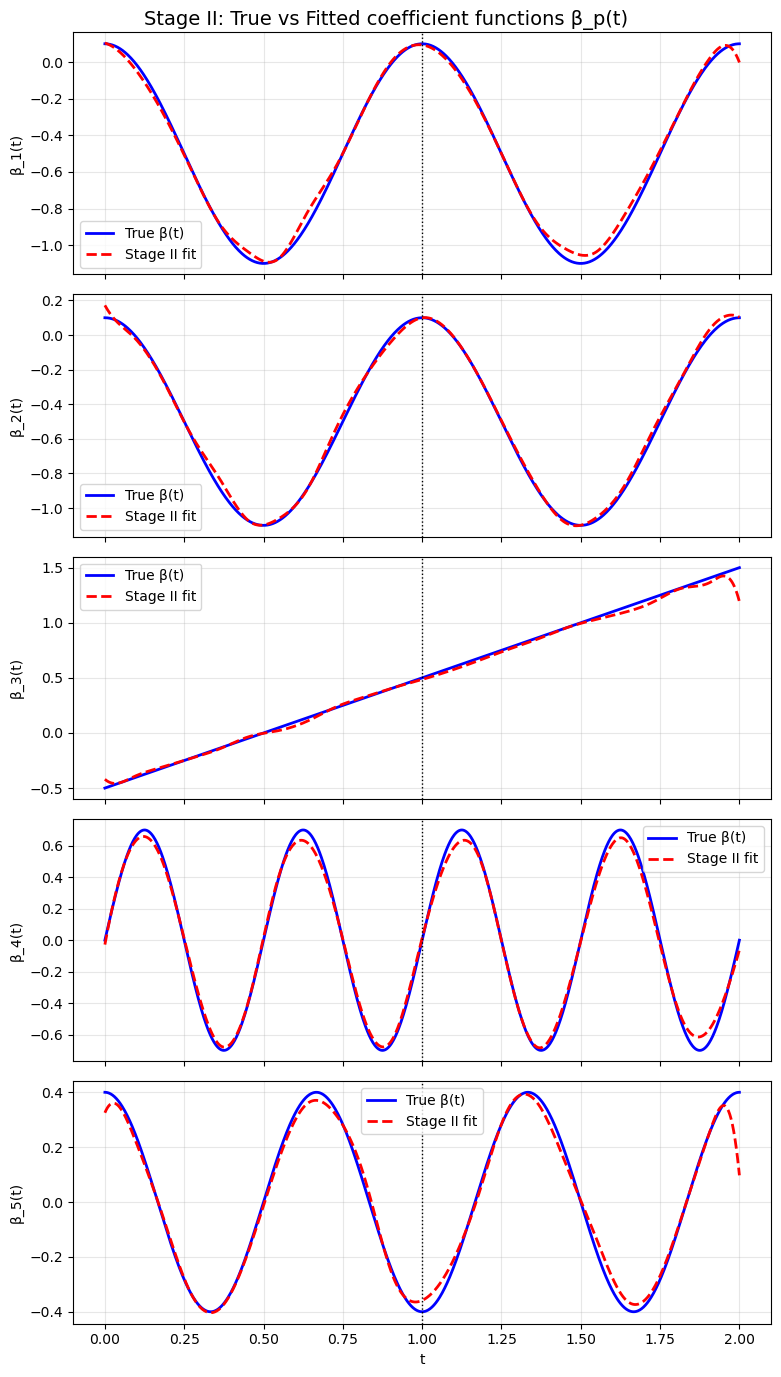

In [24]:
# ============================ 阶段 II 拟合 vs 真值 可视化 ============================

# ---------- 准备真值 ----------
# 重新生成理论真值 β_true(t)，用相同 true_funcs
funcs = true_funcs()
t_all_sorted = np.linspace(0, 2, 1000)
beta_true_all = np.zeros((len(t_all_sorted), P))
for j, idx in enumerate(signal_idx):
    beta_true_all[:, idx] = funcs[j % len(funcs)](t_all_sorted)

# ---------- 拟合值 ----------
B_eval = bspline_design_matrix(t_all_sorted, knots2, k)
betahat2_eval = np.column_stack([B_eval @ coef2[p] for p in range(P)])

# ---------- 可视化 ----------
r = min(len(signal_idx), 5)
fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r+3), sharex=True)

for ax, p in zip(axs, signal_idx[:r]):
    ax.plot(t_all_sorted, beta_true_all[:, p], 'b', lw=2, label='True β(t)')
    ax.plot(t_all_sorted, betahat2_eval[:, p], 'r--', lw=2, label='Stage II fit')
    ax.axvline(1, color='k', ls=':', lw=1)  # 阶段切换点
    ax.set_ylabel(f"β_{p}(t)")
    ax.legend(loc='best'); ax.grid(alpha=0.3)

axs[-1].set_xlabel("t")
fig.suptitle("Stage II: True vs Fitted coefficient functions β_p(t)", fontsize=14)
plt.tight_layout(); plt.show()


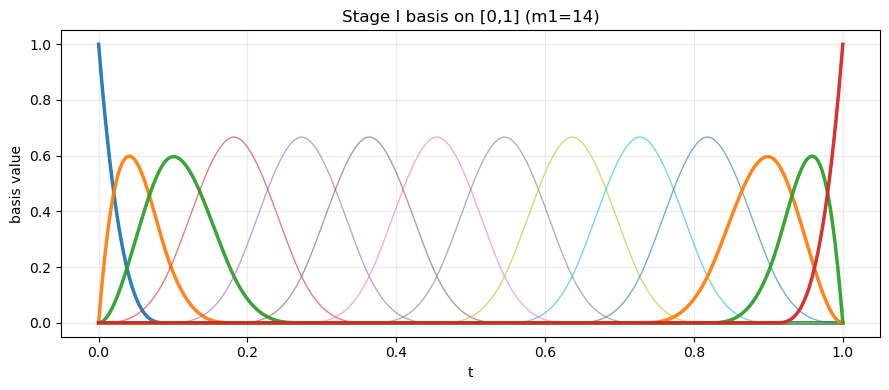

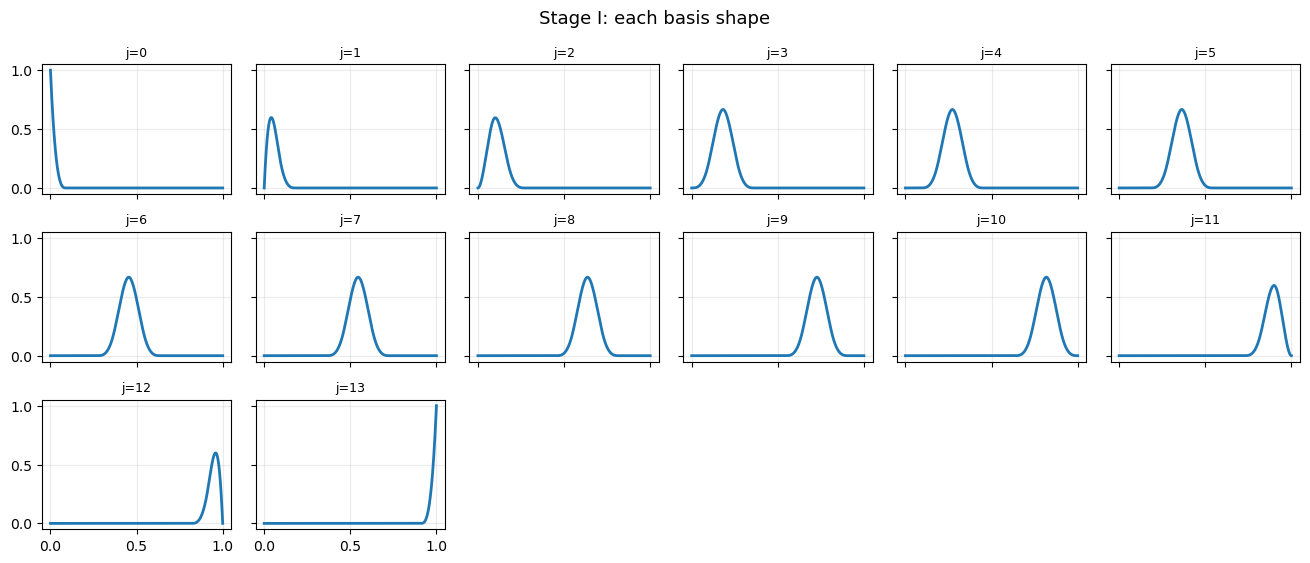

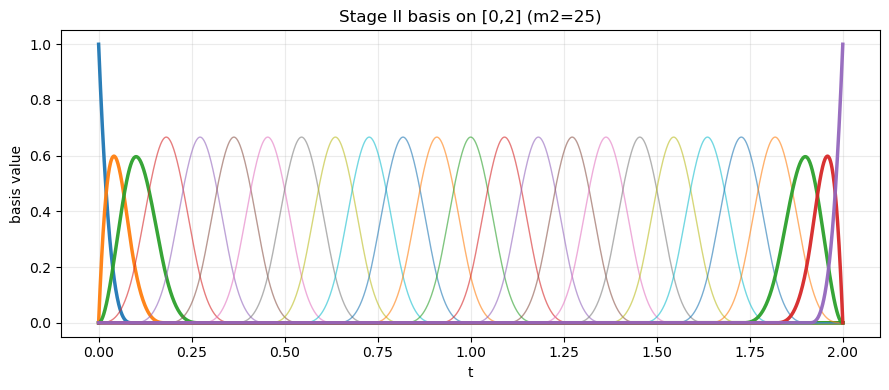

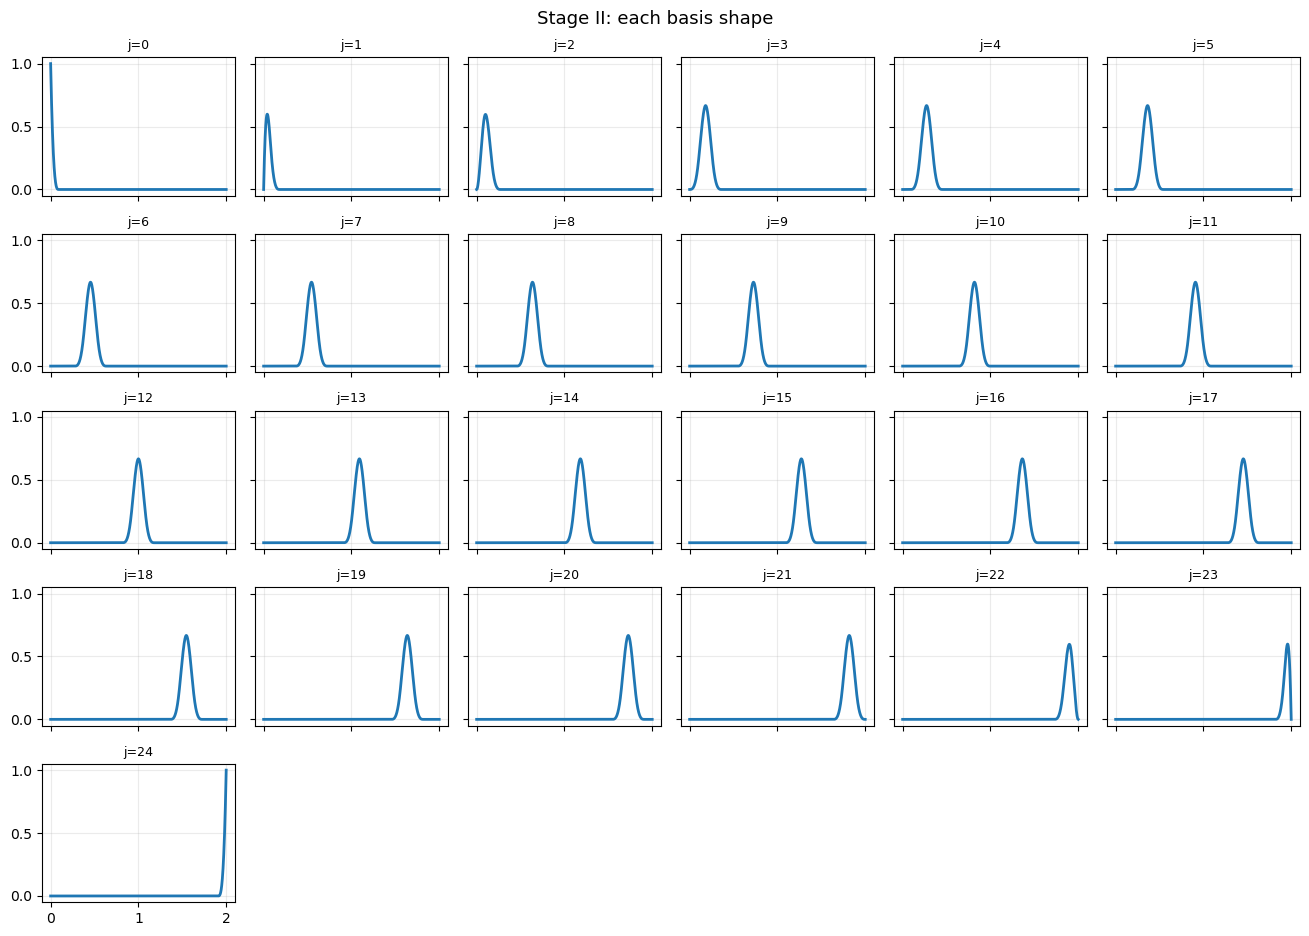

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# ===================== 基础工具 =====================
def make_open_uniform_knots(a, b, k, n_inner):
    """开放均匀结点：端点重复 k+1 次；内部等距 n_inner 个。"""
    inner = np.linspace(a, b, n_inner + 2)[1:-1] if n_inner > 0 else np.array([])
    return np.r_[np.repeat(a, k+1), inner, np.repeat(b, k+1)]

def bspline_design_matrix(x, knots, k):
    """逐列 one-hot 评估得到基矩阵 B(x)。"""
    m = len(knots) - (k + 1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j] = 1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def plot_basis_carpet(x, B, title, highlight_idx=None):
    """所有基叠画的“地毯图”。"""
    plt.figure(figsize=(9, 4))
    for j in range(B.shape[1]):
        lw = 2.5 if (highlight_idx is not None and j in highlight_idx) else 1.0
        alpha = 0.95 if (highlight_idx is not None and j in highlight_idx) else 0.6
        plt.plot(x, B[:, j], lw=lw, alpha=alpha)
    plt.title(title)
    plt.xlabel("t"); plt.ylabel("basis value")
    plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

def plot_basis_gallery(x, B, title, cols=6):
    """每个基单独一个小子图的“画廊图”。"""
    m = B.shape[1]
    rows = int(np.ceil(m / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.2, rows*1.9), sharex=True, sharey=True)
    axes = np.array(axes).reshape(rows, cols)
    for j in range(m):
        r, c = divmod(j, cols)
        ax = axes[r, c]
        ax.plot(x, B[:, j], lw=2)
        ax.set_title(f"j={j}", fontsize=9)
        ax.grid(alpha=0.25)
    # 关掉多余子图
    for j in range(m, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')
    fig.suptitle(title, fontsize=13)
    plt.tight_layout(); plt.show()

# ===================== 参数（与实验一致） =====================
k = 3                 # 三次样条
n_inner = 10          # 阶段 I 的内部结点数（=> 小区间数 N=n_inner+1）
N = n_inner + 1

# ===================== 阶段 I： [0,1]，端点 0/1 重复 =====================
knots1 = make_open_uniform_knots(0.0, 1.0, k, n_inner)   # 0 和 1 各重复 k+1
m1 = len(knots1) - (k+1)                                 # 应为 N+k
# 用致密网格画形状
x1 = np.linspace(0, 1, 1000)
B1 = bspline_design_matrix(x1, knots1, k)

# 高亮边界压缩基：左 3、右 3
highlight1 = set(range(0, 3)) | set(range(m1-3, m1))

plot_basis_carpet(x1, B1, title=f"Stage I basis on [0,1] (m1={m1})", highlight_idx=highlight1)
plot_basis_gallery(x1, B1, title="Stage I: each basis shape", cols=6)

# ===================== 阶段 II： [0,2]，仅 0/2 重复；1 为“单结点” =====================
# 左半 (0,1) 保持 N-1 个内部结点；右半 (1,2) 也放 N-1 个内部结点；1 只出现一次
left_inner  = np.linspace(0.0, 1.0, N + 1)[1:-1]     # N-1
right_inner = np.linspace(1.0, 2.0, N + 1)[1:-1]     # N-1 （不含 1 与 2）
knots2 = np.r_[np.repeat(0.0, k+1), left_inner, 1.0, right_inner, np.repeat(2.0, k+1)]
m2 = len(knots2) - (k+1)                              # 应为 2N+k

x2 = np.linspace(0, 2, 2000)
B2 = bspline_design_matrix(x2, knots2, k)

# 高亮边界压缩基：两端各 3 个；另外你也可以高亮跨 t=1 的那些基（可选）
highlight2 = set(range(0, 3)) | set(range(m2-3, m2))

plot_basis_carpet(x2, B2, title=f"Stage II basis on [0,2] (m2={m2})", highlight_idx=highlight2)
plot_basis_gallery(x2, B2, title="Stage II: each basis shape", cols=6)


In [27]:
# ============================ 全量训练 + Adaptive：在 [0,2] 上一次性拟合 ============================
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.interpolate import BSpline

# ---------- 工具函数（与阶段 I 一致） ----------
def make_open_uniform_knots(a, b, k, n_inner):
    inner = np.linspace(a, b, n_inner+2)[1:-1] if n_inner>0 else np.array([])
    return np.r_[np.repeat(a, k+1), inner, np.repeat(b, k+1)]

def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k+1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B

def build_vcm_design(B, X):
    n, m = B.shape; P = X.shape[1]
    out = np.zeros((n, m*P))
    for p in range(P):
        out[:, p*m:(p+1)*m] = X[:, [p]] * B
    return out

def split_blocks(vec, m, P): return [vec[p*m:(p+1)*m] for p in range(P)]

def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid); w[0]*=0.5; w[-1]*=0.5; w *= (b-a)/(grid-1)
    return B.T @ (B * w[:,None])

def group_weights(B, X):
    row_e = np.sum(B*B, axis=1)
    return np.sqrt((X**2 * row_e[:,None]).sum(0)/B.shape[0] + 1e-12)

def lambda_max_R(XtB, y, m, R):
    L = np.linalg.cholesky(R)
    P = XtB.shape[1]//m
    lam = 0.0
    for p in range(P):
        g = XtB[:, p*m:(p+1)*m].T @ y
        u = np.linalg.solve(L.T, g)
        lam = max(lam, float(norm(u)))
    return lam

def group_soft_thresh(blocks, tau, R, lam, w):
    out=[]
    for v,wp in zip(blocks,w):
        nr=float(np.sqrt(max(0.0, v.T@R@v))); thr=tau*lam*wp
        out.append(np.zeros_like(v) if nr<=thr else (1-thr/nr)*v)
    return out

def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=3000, tol=1e-6):
    d=m*P
    Ls=float(np.linalg.norm(XtX,2))
    Ls = Ls if (np.isfinite(Ls) and Ls>0) else 1.0
    step=1.0/Ls; c=np.zeros(d); z=c.copy(); tN=1.0
    for _ in range(max_iter):
        grad= XtX@z - Xty
        yv  = z - step*grad
        yb  = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))
        t_new = 0.5*(1+np.sqrt(1+4*tN*tN))
        z = c_new + (tN-1)/t_new*(c_new-c)
        if norm(c_new-c) <= tol*max(1.0, norm(c)):
            return c_new
        c, tN = c_new, t_new
    return c

def kfold_indices(n,K=5,seed=0):
    rng=np.random.default_rng(seed); idx=np.arange(n); rng.shuffle(idx)
    return np.array_split(idx,K)

def cv_select_lambda(B,X,y,R,w,lams,K=5,seed=2025,use_1se=True):
    n,m=B.shape; P=X.shape[1]; folds=kfold_indices(n,K,seed)
    mse=np.zeros((len(lams),K))
    for li,lam in enumerate(lams):
        for kf,val in enumerate(folds):
            tr=np.setdiff1d(np.arange(n),val)
            Btr,Bv=B[tr],B[val]; Xtr,Xv=X[tr],X[val]; ytr,yv=y[tr],y[val]
            XtBtr=build_vcm_design(Btr,Xtr); XtBv=build_vcm_design(Bv,Xv)
            XtX=XtBtr.T@XtBtr; Xty=XtBtr.T@ytr
            c=fista_group_lasso(XtX,Xty,lam,m,P,R,w)
            mse[li,kf]=np.mean((yv - XtBv@c)**2)
    mm=mse.mean(1); best=int(np.argmin(mm))
    if use_1se:
        se=mse.std(1,ddof=1)/np.sqrt(K); thr=mm[best]+se[best]
        best=int(np.where(mm<=thr)[0][0])
    return float(lams[best]), mm, mse

def group_selection_by_Rnorm(coef_blocks, R, tol=1e-6):
    r = np.array([float(np.sqrt(max(0.0, cb.T @ R @ cb))) for cb in coef_blocks])
    sel = np.where(r > tol)[0].tolist()
    return sel, r

# ---------- 自适应一次（全量） ----------
def adaptive_once_full(B, X, y, R, c_init, k, knots, use_1se=True, delta=1.0, eps=1e-6, seed=2025):
    """
    基于初解 c_init 的组 R-范数 r0 构造权重 w_adapt = 1/(r0+eps)^delta，
    在同一基上重新做一轮 CV + FISTA。
    """
    n, m = B.shape; P = X.shape[1]
    blocks0 = split_blocks(c_init, m, P)
    r0 = np.array([float(np.sqrt(max(0.0, cb.T @ R @ cb))) for cb in blocks0])
    w_adapt = 1.0 / (r0 + eps)**delta

    XtB = build_vcm_design(B, X)
    lam_max = lambda_max_R(XtB, y, m, R)
    lambdas = np.geomspace(lam_max, lam_max*5e-4, 30)

    lam_ad, _, _ = cv_select_lambda(B, X, y, R, w_adapt, lambdas, K=5, seed=seed, use_1se=use_1se)
    XtX, Xty = XtB.T @ XtB, XtB.T @ y
    c_ad = fista_group_lasso(XtX, Xty, lam_ad, m, P, R, w_adapt, max_iter=6000, tol=1e-7)
    blocks_ad = split_blocks(c_ad, m, P)
    return lam_ad, c_ad, blocks_ad, w_adapt

# ---------- 生成数据（与阶段 I 风格相同：区间内归一化） ----------
def true_funcs(scales=None):
    if scales is None: scales=[1.0,1.0,1.0,1.0,1.0]
    return [
        lambda u: scales[0]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[1]*(-0.5+0.6*np.cos(2*np.pi*u)),
        lambda u: scales[2]*(u-0.5),
        lambda u: scales[3]*(0.7*np.sin(4*np.pi*u)),
        lambda u: scales[4]*(0.4*np.cos(3*np.pi*u)),
    ]

def gen_interval(funcs,a,b,n,P,signal_idx,sigma,seed,normalize_within=True):
    rng=np.random.default_rng(seed)
    t=np.sort(rng.uniform(a,b,n))
    X=rng.standard_normal((n,P)); X=(X-X.mean(0))/(X.std(0)+1e-12)
    u=(t-a)/(b-a) if normalize_within else t
    beta=np.zeros((n,P))
    for j,idx in enumerate(signal_idx):
        beta[:,idx]=funcs[j%len(funcs)](u)
    y=(X*beta).sum(1)+sigma*rng.standard_normal(n)
    return t,X,y,beta

# ---------- 超参 ----------
k=3
n_inner=10
P=100; n=400; noise_sigma=0.1
seed_data=0; seed_cv=2025; use_1se=True
signal_idx=[1,2,3,4,5]
funcs = true_funcs()

# ---------- 构造在 [0,2] 的数据（两段各 n） ----------
t1,X1,y1,_ = gen_interval(funcs,0,1,n,P,signal_idx,noise_sigma,seed_data,normalize_within=True)
t2,X2,y2,_ = gen_interval(funcs,1,2,n,P,signal_idx,noise_sigma,seed_data+1,normalize_within=True)
t_all = np.r_[t1, t2]
X_all = np.vstack([X1, X2])
y_all = np.r_[y1, y2]
n_all = t_all.shape[0]

# ---------- 结点与基（与阶段 II 保持相同基数 m2=24） ----------
left_inner  = np.linspace(0,1,n_inner+2)[1:-1]    # 10
right_inner = np.linspace(1,2,n_inner+2)[1:-1]    # 10（含1）
knots2 = np.r_[np.repeat(0.0,k+1), left_inner, 1.0, right_inner[1:], np.repeat(2.0,k+1)]
# 内部结点数 = 10 + 1 + 9 = 20; m2 = 20 + k + 1 = 24

# ============================ 初次（非自适应）阶段 ============================
tic = time.time()

B2 = bspline_design_matrix(t_all, knots2, k)
R2 = gram_R(knots2, k, 0.0, 2.0)
w2 = group_weights(B2, X_all)
XtB2 = build_vcm_design(B2, X_all)
lammax = lambda_max_R(XtB2, y_all, B2.shape[1], R2)
lams2 = np.geomspace(lammax, lammax*5e-4, 30)

t0_cv_start = time.time()
lam2, mm0, mse0 = cv_select_lambda(B2, X_all, y_all, R2, w2, lams2, K=5, seed=seed_cv, use_1se=use_1se)
t0_cv_end = time.time()

XtX2 = XtB2.T @ XtB2
Xty2 = XtB2.T @ y_all
c2_0   = fista_group_lasso(XtX2, Xty2, lam2, B2.shape[1], P, R2, w2, max_iter=6000, tol=1e-7)
t0_solve_end = time.time()

yhat0 = XtB2 @ c2_0
rmse0 = float(np.sqrt(np.mean((y_all - yhat0)**2)))
blocks0 = split_blocks(c2_0, B2.shape[1], P)
sel0, _ = group_selection_by_Rnorm(blocks0, R2, tol=1e-6)

# ============================ 自适应阶段（一次迭代） ============================
t1_adapt_weight = time.time()
lam2_ad, c2_ad, blocks_ad, w2_ad = None, None, None, None
# 计算自适应权重并重新CV+求解
lam2_ad, c2_ad, blocks_ad, w2_ad = adaptive_once_full(
    B2, X_all, y_all, R2, c2_0, k, knots2, use_1se=use_1se, delta=1.0, eps=1e-6, seed=seed_cv
)
t1_adapt_end = time.time()

yhat_ad = XtB2 @ c2_ad
rmse_ad = float(np.sqrt(np.mean((y_all - yhat_ad)**2)))
sel_ad, _ = group_selection_by_Rnorm(blocks_ad, R2, tol=1e-6)

t_all_end = time.time()

# ---------- 打印耗时与结果 ----------
print(f"[Full [0,2]] m2={B2.shape[1]} (应为 24)")
print(f"  初次λ*={lam2:.3e},  Train RMSE={rmse0:.4f},  选中组数={len(sel0)}（前30：{sorted(sel0)[:30]}）")
print(f"  自适应λ_ad*={lam2_ad:.3e},  Train RMSE={rmse_ad:.4f},  选中组数={len(sel_ad)}（前30：{sorted(sel_ad)[:30]}）")

print("\n[计时信息]（单位：秒）")
print(f"  初次 K 折交叉验证 (CV)   : {t0_cv_end - t0_cv_start:8.3f}")
print(f"  初次 FISTA 求解         : {t0_solve_end - t0_cv_end:8.3f}")
print(f"  自适应（权重+CV+求解）  : {t1_adapt_end - t1_adapt_weight:8.3f}")
print(f"  总耗时（端到端）         : {t_all_end - tic:8.3f}")

# ----------（可选）可视化：仅看真信号组 ----------
# r = min(len(signal_idx), 5)
# order = np.argsort(t_all)
# betahat_ad = np.column_stack([B2 @ blocks_ad[p] for p in range(P)])  # 只是组块，还需拼列：这里已是完整 c2_ad 切块
# betahat_ad = np.column_stack([B2 @ split_blocks(c2_ad, B2.shape[1], P)[p] for p in range(P)])
# fig,axs=plt.subplots(r,1,figsize=(7,1.8*r+3),sharex=True)
# for ax,p in zip(axs, signal_idx[:r]):
#     ax.plot(t_all[order], (B2 @ split_blocks(c2_0, B2.shape[1], P)[p])[order], 'r--', lw=1, label='Full (init)')
#     ax.plot(t_all[order], (B2 @ split_blocks(c2_ad, B2.shape[1], P)[p])[order], 'r', lw=2, label='Full (adaptive)')
#     ax.grid(alpha=0.3); ax.legend()
# axs[-1].set_xlabel("t"); plt.tight_layout(); plt.show()


[Full [0,2]] m2=24 (应为 24)
  初次λ*=1.232e+00,  Train RMSE=0.1398,  选中组数=33（前30：[1, 2, 3, 4, 5, 8, 9, 10, 14, 16, 19, 20, 21, 29, 32, 38, 42, 52, 55, 56, 57, 62, 64, 65, 70, 75, 79, 80, 88, 92]）
  自适应λ_ad*=3.324e-01,  Train RMSE=0.1580,  选中组数=5（前30：[1, 2, 3, 4, 5]）

[计时信息]（单位：秒）
  初次 K 折交叉验证 (CV)   :  236.986
  初次 FISTA 求解         :    1.952
  自适应（权重+CV+求解）  :  212.869
  总耗时（端到端）         :  451.830
